
# Zajęcia ML — Wariant 9: Parkinson (`pd_speech_features.csv`)


In [1]:

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             confusion_matrix, classification_report, RocCurveDisplay)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)


In [5]:

# === 1. Wczytanie danych
csv_path = Path(r"C:\Users\Administrator\Desktop\Studia\Semestr 1\Uczenie Maszynowe L\Laboratorium 1\pd_speech_features.csv")
assert csv_path.exists(), "Brak pliku pd_speech_features.csv w katalogu notebooka."
df = pd.read_csv(csv_path)

print("Wymiary:", df.shape)
display(df.head(3))
print("Podgląd kolumn:", list(df.columns)[:25], "...")


Wymiary: (756, 755)


,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,GNE_SNR_SEO,GNE_NSR_TKEO,GNE_NSR_SEO,VFER_mean,VFER_std,VFER_entropy,VFER_SNR_TKEO,VFER_SNR_SEO,VFER_NSR_TKEO,VFER_NSR_SEO,IMF_SNR_SEO,IMF_SNR_TKEO,IMF_SNR_entropy,IMF_NSR_SEO,IMF_NSR_TKEO,IMF_NSR_entropy,mean_Log_energy,mean_MFCC_0th_coef,mean_MFCC_1st_coef,mean_MFCC_2nd_coef,...,tqwt_skewnessValue_dec_14,tqwt_skewnessValue_dec_15,tqwt_skewnessValue_dec_16,tqwt_skewnessValue_dec_17,tqwt_skewnessValue_dec_18,tqwt_skewnessValue_dec_19,tqwt_skewnessValue_dec_20,tqwt_skewnessValue_dec_21,tqwt_skewnessValue_dec_22,tqwt_skewnessValue_dec_23,tqwt_skewnessValue_dec_24,tqwt_skewnessValue_dec_25,tqwt_skewnessValue_dec_26,tqwt_skewnessValue_dec_27,tqwt_skewnessValue_dec_28,tqwt_skewnessValue_dec_29,tqwt_skewnessValue_dec_30,tqwt_skewnessValue_dec_31,tqwt_skewnessValue_dec_32,tqwt_skewnessValue_dec_33,tqwt_skewnessValue_dec_34,tqwt_skewnessValue_dec_35,tqwt_skewnessValue_dec_36,tqwt_kurtosisValue_dec_1,tqwt_kurtosisValue_dec_2,tqwt_kurtosisValue_dec_3,tqwt_kurtosisValue_dec_4,tqwt_kurtosisValue_dec_5,tqwt_kurtosisValue_dec_6,tqwt_kurtosisValue_dec_7,tqwt_kurtosisValue_dec_8,tqwt_kurtosisValue_dec_9,tqwt_kurtosisValue_dec_10,tqwt_kurtosisValue_dec_11,tqwt_kurtosisValue_dec_12,tqwt_kurtosisValue_dec_13,tqwt_kurtosisValue_dec_14,tqwt_kurtosisValue_dec_15,tqwt_kurtosisValue_dec_16,tqwt_kurtosisValue_dec_17,tqwt_kurtosisValue_dec_18,tqwt_kurtosisValue_dec_19,tqwt_kurtosisValue_dec_20,tqwt_kurtosisValue_dec_21,tqwt_kurtosisValue_dec_22,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,0.000018,0.00067,0.00129,0.00200,0.05883,0.517,0.03011,0.03496,0.04828,0.09034,0.970805,0.036223,18.995,69.997496,76.088046,72.465512,539.342735,1031.849040,2447.162183,3655.054806,101.092218,83.147440,255.214830,396.643631,0.77778,11.7245,2.8277,1.17300,0.26512,0.083127,1200445.612,1.5347,3.0152,0.000463,0.000260,0.83621,209.6062,455.9654,1.2825,1.3305,51.6843,5.7784,23.2610,0.26850,5.8573,0.20023,9.1817,11.4283,8.4781,2.4874,...,-0.003143,0.007433,1.510000e-17,2.210000e-17,-9.370000e-18,0.000734,-4.330000e-18,-4.470000e-17,-1.390000e-17,-3.500000e-17,-4.290000e-19,-9.660000e-18,-1.660000e-17,0.000115,-0.102900,0.030756,7.070000e-17,-0.086911,-0.28507,-0.173620,0.071728,0.010352,-2.73030,66.5007,36.9934,26.3508,51.9577,21.5451,8.2488,8.0024,6.9635,6.9189,5.0622,4.6068,7.7218,2.7224,2.4171,2.9383,4.2077,3.1541,2.8531,2.7496,2.1550,2.9457,2.1993,1.9830,1.8314,2.0062,1.6058,1.5466,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,0.000016,0.00052,0.00112,0.00157,0.05516,0.502,0.02320,0.03675,0.06195,0.06961,0.984322,0.017974,21.497,67.415903,73.046374,71.528945,564.363615,1016.367294,2383.565201,3498.681572,58.465428,86.487292,248.357127,218.229722,0.81250,13.8284,2.8908,1.02210,0.22004,0.127410,1298455.445,1.6029,3.0600,0.000615,0.000295,1.04550,243.0816,379.8429,1.3063,1.3177,24.0230,6.7916,21.8851,0.26839,6.2366,0.20336,9.6074,12.1387,8.5008,2.8986,...,0.006114,-0.000092,-7.090000e-18,-3.910000e-18,8.750000e-18,0.000330,-9.330000e-19,-7.020000e-20,-1.010000e-17,1.520000e-17,-5.590000e-18,8.090000e-18,-6.280000e-18,0.000098,-0.005679,-0.205900,3.630000e-16,0.482840,0.50453,0.6842

Podgląd kolumn: ['id', 'gender', 'PPE', 'DFA', 'RPDE', 'numPulses', 'numPeriodsPulses', 'meanPeriodPulses', 'stdDevPeriodPulses', 'locPctJitter', 'locAbsJitter', 'rapJitter', 'ppq5Jitter', 'ddpJitter', 'locShimmer', 'locDbShimmer', 'apq3Shimmer', 'apq5Shimmer', 'apq11Shimmer', 'ddaShimmer', 'meanAutoCorrHarmonicity', 'meanNoiseToHarmHarmonicity', 'meanHarmToNoiseHarmonicity', 'minIntensity', 'maxIntensity'] ...


In [6]:

# === 2. Kolumna klasy (binarny cel klasyfikacji)
candidate_labels = [c for c in df.columns if c.lower() in {"class","status","target","label"}]
assert len(candidate_labels) >= 1, "Nie znaleziono kolumny klasy (sprawdź nazwy w pliku)."
LABEL_COL = candidate_labels[0]
print("Kolumna klasy:", LABEL_COL)

# Rzutowanie na int (w razie potrzeby)
df[LABEL_COL] = df[LABEL_COL].astype(int)
print(df[LABEL_COL].value_counts(dropna=False))


Kolumna klasy: class
class
1    564
0    192
Name: count, dtype: int64


In [7]:

# === 3. Wstępne czyszczenie danych
# Usuwamy kolumny stałe i ewidentne ID (zawierające 'id' lub 'name')
drop_cols = []
for col in df.columns:
    if df[col].nunique(dropna=True) <= 1:
        drop_cols.append(col)
    if "id" in col.lower() or "name" in col.lower():
        drop_cols.append(col)

drop_cols = sorted(set(drop_cols) - {LABEL_COL})
if drop_cols:
    print("Usuwam stałe/ID:", drop_cols)
    df = df.drop(columns=drop_cols)

# Obsługa braków danych — startowo: usuń wiersze z brakami (prosto i bezpiecznie)
before = df.shape
df = df.dropna(axis=0)
after = df.shape
print(f"Po dropna: {before} -> {after}")


Usuwam stałe/ID: ['id']
Po dropna: (756, 754) -> (756, 754)


In [8]:

# === 4. Regresja: wybór zmiennej ciągłej
# Możesz wymusić konkretny cel, np.: REGRESSION_TARGET = "age"
REGRESSION_TARGET = None  # <- ustaw własną nazwę kolumny jeśli chcesz nadpisać wybór

if REGRESSION_TARGET is None:
    preferred_targets = ["age"]
    for t in preferred_targets:
        if t in df.columns and t != LABEL_COL:
            REGRESSION_TARGET = t
            break

if REGRESSION_TARGET is None:
    numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != LABEL_COL]
    variances = df[numeric_cols].var().sort_values(ascending=False)
    REGRESSION_TARGET = variances.index[0]

print("Cel regresji:", REGRESSION_TARGET)
assert REGRESSION_TARGET in df.columns, "Nie znaleziono wybranej kolumny regresji w danych."
assert REGRESSION_TARGET != LABEL_COL, "Cel regresji nie może być kolumną klasy."


Cel regresji: app_entropy_shannon_10_coef


In [9]:

# === 5. Podział danych
# Klasyfikacja (stratyfikacja)
X_cls = df.drop(columns=[LABEL_COL, REGRESSION_TARGET]) if REGRESSION_TARGET in df.columns else df.drop(columns=[LABEL_COL])
y_cls = df[LABEL_COL]

Xtr_c, Xte_c, ytr_c, yte_c = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls)

# Regresja
X_reg = df.drop(columns=[LABEL_COL, REGRESSION_TARGET])
y_reg = df[REGRESSION_TARGET]

Xtr_r, Xte_r, ytr_r, yte_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

print("Cechy (klasyfikacja)  :", Xtr_c.shape, " / Test:", Xte_c.shape)
print("Cechy (regresja)      :", Xtr_r.shape, " / Test:", Xte_r.shape)


Cechy (klasyfikacja)  : (604, 752)  / Test: (152, 752)
Cechy (regresja)      : (604, 752)  / Test: (152, 752)


In [10]:

# === 6. Pipeline'y + SVM (GridSearch)
num_cols_c = Xtr_c.columns.tolist()
num_cols_r = Xtr_r.columns.tolist()

num_tf_c = ColumnTransformer([("scale", StandardScaler(), num_cols_c)], remainder="drop")
num_tf_r = ColumnTransformer([("scale", StandardScaler(), num_cols_r)], remainder="drop")

svc = SVC(probability=True, class_weight="balanced", random_state=42)
pipe_svc = Pipeline(steps=[("prep", num_tf_c), ("clf", svc)])

param_grid = {
    "clf__kernel": ["linear", "rbf"],
    "clf__C": [0.1, 1, 10, 100],
    "clf__gamma": ["scale", "auto"]  # ignorowane przy kernel='linear'
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipe_svc, param_grid, cv=cv, scoring="f1", n_jobs=-1)
gs.fit(Xtr_c, ytr_c)

print("=== Najlepszy SVM ===")
print(gs.best_params_)
best_svc = gs.best_estimator_


=== Najlepszy SVM ===
{'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}



--- Klasyfikacja (test) ---
Accuracy : 0.8947368421052632
Precision: 0.907563025210084
Recall   : 0.9557522123893806
F1       : 0.9310344827586207
ROC-AUC  : 0.9442931699568867

Raport:
               precision    recall  f1-score   support

           0      0.848     0.718     0.778        39
           1      0.908     0.956     0.931       113

    accuracy                          0.895       152
   macro avg      0.878     0.837     0.854       152
weighted avg      0.892     0.895     0.892       152

Macierz pomyłek:
 [[ 28  11]
 [  5 108]]


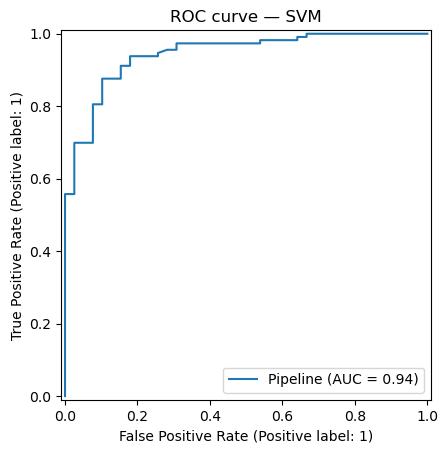

In [11]:

# === 6b. Ewaluacja klasyfikacji
proba = best_svc.predict_proba(Xte_c)[:, 1]
pred = (proba >= 0.5).astype(int)

print("\n--- Klasyfikacja (test) ---")
print("Accuracy :", accuracy_score(yte_c, pred))
print("Precision:", precision_score(yte_c, pred, zero_division=0))
print("Recall   :", recall_score(yte_c, pred))
print("F1       :", f1_score(yte_c, pred))
try:
    print("ROC-AUC  :", roc_auc_score(yte_c, proba))
except Exception as e:
    print("ROC-AUC  (brak):", e)
print("\nRaport:\n", classification_report(yte_c, pred, digits=3))
print("Macierz pomyłek:\n", confusion_matrix(yte_c, pred))

_ = RocCurveDisplay.from_estimator(best_svc, Xte_c, yte_c)
plt.title("ROC curve — SVM")
plt.show()


In [12]:

# === 7. Regresja liniowa
linreg = Pipeline(steps=[("prep", num_tf_r), ("reg", LinearRegression())])

# CV informacyjnie
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2 = cross_val_score(linreg, Xtr_r, ytr_r, cv=kfold, scoring="r2")
print("\n=== Regresja liniowa (CV, R²) ===")
print(cv_r2, "średnio:", np.mean(cv_r2))

linreg.fit(Xtr_r, ytr_r)
yhat = linreg.predict(Xte_r)

mae = mean_absolute_error(yte_r, yhat)
mse = mean_squared_error(yte_r, yhat)
rmse = np.sqrt(mse)
r2 = r2_score(yte_r, yhat)

print("\n--- Regresja (test) ---")
print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)



=== Regresja liniowa (CV, R²) ===
[0.99646326 0.99820199 0.99284827 0.9951352  0.97723988] średnio: 0.9919777192042796

--- Regresja (test) ---
MAE : 83349488.44972773
RMSE: 136266823.49197578
R²  : 0.9996830552982623



## Notatki i pomysły na rozszerzenia
- Balans klas: rozważ `class_weight` lub oversampling (SMOTE).
- Selekcja cech: PCA albo filtry (np. korelacje) mogą poprawić stabilność SVM.
- Inne modele: dla porównania możesz dodać Logistic Regression / Random Forest i Ridge/Lasso dla regresji.
- Walidacja: użyj większej liczby foldów lub nested CV do bardziej rzetelnej oceny.
